# Interpretability of pain behavior recognition

## First we need dataframes for every subject

In [21]:
import sys
sys.path.append('../')

%matplotlib inline

# DEFINE GRAPH
import pandas as pd
import numpy as np
import utils

from importlib import reload
reload(utils)

pd.set_option('max_colwidth', 800) 

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Data paths
rgb_path = '../data/jpg_128_128_2fps/'
of_path = '../data/jpg_128_128_16fps_OF_magnitude_cv2/'

# Hyperparameters
input_width = 128
input_height = 128
seq_length = 10
seq_stride = 10
batch_size = 1
COLOR = True
nb_labels = 2

# Data augmentation
aug_flip = 0
aug_crop = 0
aug_light = 0

subject_ids = pd.read_csv('../metadata/horse_subjects.csv')['Subject'].values
channels = 3

In [4]:
from utils import ArgsProxy
args = ArgsProxy(rgb_path, of_path, input_height, input_width,
                 seq_length, seq_stride, batch_size, nb_labels,
                 aug_flip, aug_crop, aug_light)

In [5]:
import data_handler as dathand
dh = dathand.DataHandler(path=args.data_path,
                 of_path=args.of_path,
                 clip_list_file='videos_overview_missingremoved.csv',
                 data_columns=['Pain'],  # Here one can append f. ex. 'Observer'
                 image_size=(args.input_height, args.input_width),
                 seq_length=args.seq_length,
                 seq_stride=args.seq_stride,
                 batch_size=args.batch_size,
                 color=COLOR,
                 nb_labels=args.nb_labels,
                 aug_flip=args.aug_flip,
                 aug_crop=args.aug_crop,
                 aug_light=args.aug_light)

In [6]:
import utils
subject_dfs = utils.read_or_create_subject_dfs(dh, args, subject_ids)

../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/


In [7]:
subject_dfs = utils.read_or_create_subject_rgb_and_OF_dfs(dh, args, subject_ids, subject_dfs)

In [8]:
sequence_df = utils.get_sequence(args=args, subject_dfs=subject_dfs, subject=4)
y = sequence_df['Pain'].values
image_paths = sequence_df['Path'].values
of_paths = sequence_df['OF_Path'].values

Chose subject  4
Start index in subject dataframe:  10814


In [9]:
from keras.utils import np_utils
label_onehot = np_utils.to_categorical(y, num_classes=args.nb_labels)
label_onehot
batch_label = label_onehot.reshape(args.batch_size, args.seq_length, -1)

batch_img = np.concatenate(utils.read_images_and_return_list(args, image_paths, 'local'), axis=1)
batch_flow = np.concatenate(utils.read_images_and_return_list(args, of_paths, 'local'), axis=1)

## Now that we have frames from all subjects, we can import gradcam functionality

In [10]:
# Choose a model to work on
two_stream = True

if two_stream: # This model got 88.09 % F1-score
    best_model_path = '../models/BEST_MODEL_2stream_5d_adadelta_LSTMunits_32_CONVfilters_16_add_v4_t0_4hl_128jpg2fps_seq10_bs8_adadelta_noaug_run1_rerun_for_gradcam.h5'
else:
    best_model_path = '../models/1stream_summer_2018/no_aug/BEST_MODEL_convolutional_LSTM_adadelta_LSTMunits_32_CONVfilters_None_jpg128_2fps_val0_t4_seq10ss10_4hl_32ubs16_no_aug_run4.h5'
import keras
m = keras.models.load_model(best_model_path)

In [11]:
from keras import backend as K
import tensorflow as tf
    
images = tf.placeholder(tf.float32, [batch_size, args.seq_length, args.input_width, args.input_height, channels])
flows = tf.placeholder(tf.float32, [batch_size, args.seq_length, args.input_width, args.input_height, channels])
labels = tf.placeholder(tf.float32, [batch_size, args.seq_length, 2])

if two_stream:
    clstm_model = utils.TwoStreamCLSTMNetwork(images, flows, from_scratch=0, path=best_model_path)
else:
    clstm_model = utils.CLSTMNetwork(images, from_scratch=0, path=best_model_path)

sess = K.get_session()  # Grab the Keras session where the weights are initialized.

cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(clstm_model.preds)), axis=1)
    
y_c = tf.reduce_sum(tf.multiply(clstm_model.dense, labels), axis=1)

print('model preds: ', clstm_model.preds)
print('cost: ', cost)
print('y_c: ', y_c)


    
if two_stream:
    target_conv_layer = clstm_model.clstm1_rgb # Choose which CLSTM-layer to study
    # target_conv_layer = clstm_model.merge # Choose which CLSTM-layer to study
else:
    target_conv_layer = clstm_model.clstm4 # Choose which CLSTM-layer to study
    
print('tcl: ', target_conv_layer)
print('TYPE tcl: ', type(target_conv_layer))
    
target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

print('tclg: ', target_conv_layer_grad)
    
gb_grad = tf.gradients(cost, [images, flows])[0]  # Guided backpropagation back to input layer

model preds:  Tensor("activation_1_2/Sigmoid:0", shape=(1, 10, 2), dtype=float32)
cost:  Tensor("mul_1:0", shape=(1, 2), dtype=float32)
y_c:  Tensor("Sum_1:0", shape=(1, 2), dtype=float32)
tcl:  Tensor("conv_lst_m2d_1_2/transpose_1:0", shape=(1, ?, 128, 128, 32), dtype=float32)
TYPE tcl:  <class 'tensorflow.python.framework.ops.Tensor'>
tclg:  Tensor("gradients/time_distributed_1_2/transpose_grad/transpose:0", shape=(1, ?, 128, 128, 32), dtype=float32)


In [14]:
def run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True):
    with sess.as_default():

        # 2-stream
        if two_stream:
            prob = sess.run(clstm_model.preds,
                            feed_dict={images: batch_img,
                                       flows: batch_flow,
                                       K.learning_phase(): 0})

            print(prob)

            gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value =                 sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
                          feed_dict={images: batch_img,
                                     flows: batch_flow,
                                     labels: batch_label,
                                     K.learning_phase(): 0})

#             target_conv_layer_value = np.reshape(target_conv_layer_value,
#                                              (1, 10, 8, 8, 32))
#             target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
#                                              (1, 10, 8, 8, 32))
            
            target_conv_layer_value = np.reshape(target_conv_layer_value,
                                 (1, 10, 128, 128, 32))
            target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
                                             (1, 10, 128, 128, 32))
        else:
            prob = sess.run(clstm_model.preds,
                            feed_dict={images: batch_img,
                                       K.learning_phase(): 0})

            print(prob)
            gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value =                 sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
                          feed_dict={images: batch_img,
                          labels: batch_label,
                          K.learning_phase(): 0})
            target_conv_layer_value = np.reshape(target_conv_layer_value,
                                         (1, 10, 16, 16, 32))
            target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
                                         (1, 10, 16, 16, 32))


        utils.visualize_overlays(batch_img, target_conv_layer_value,
                           target_conv_layer_grad_value, batch_flow)


# Two-stream predictions for subject 0

Chose subject  0
Start index in subject dataframe:  13483
                                                   Path  Pain
0  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000710.jpg     1
1  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000711.jpg     1
2  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000712.jpg     1
3  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000713.jpg     1
4  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000714.jpg     1
5  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000715.jpg     1
6  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000716.jpg     1
7  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000717.jpg     1
8  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000718.jpg     1
9  data/jpg_128_128_2fps/horse_1/1_5_1/frame_000719.jpg     1
[[[0.6846968  0.27315986]
  [0.7593778  0.24551192]
  [0.6346743  0.3401713 ]
  [0.37649024 0.36941874]
  [0.19782948 0.39786345]
  [0.12362128 0.49774623]
  [0.10904063 0.56772214]
  [0.11761758 0.5729059 ]
  [0.11684264 0.5050181 ]
  [0.15307458 0.44583526]]

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


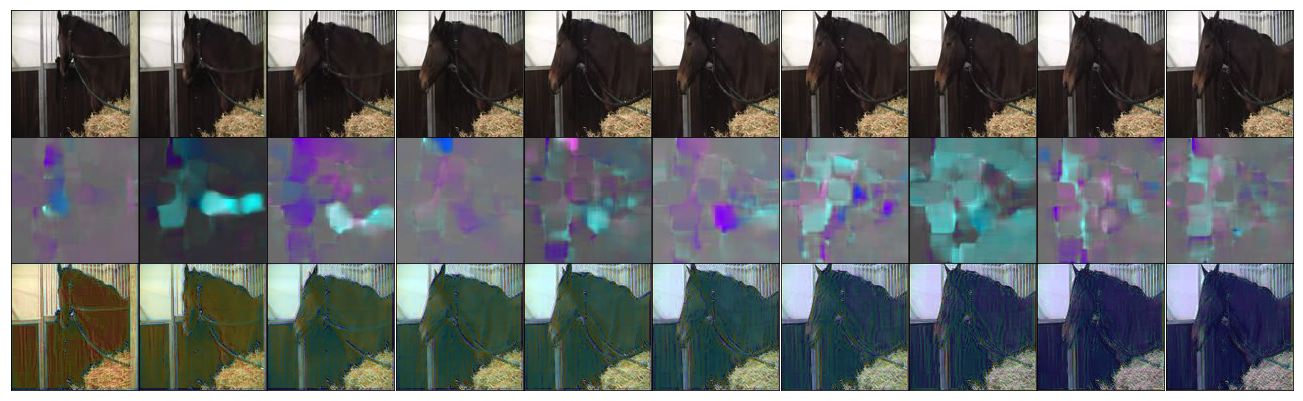

In [16]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=0)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  0
Start index in subject dataframe:  5926
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_1/1_2a/frame_002279.jpg     0
1  data/jpg_128_128_2fps/horse_1/1_2a/frame_002280.jpg     0
2  data/jpg_128_128_2fps/horse_1/1_2a/frame_002281.jpg     0
3  data/jpg_128_128_2fps/horse_1/1_2a/frame_002282.jpg     0
4  data/jpg_128_128_2fps/horse_1/1_2a/frame_002283.jpg     0
5  data/jpg_128_128_2fps/horse_1/1_2a/frame_002284.jpg     0
6  data/jpg_128_128_2fps/horse_1/1_2a/frame_002285.jpg     0
7  data/jpg_128_128_2fps/horse_1/1_2a/frame_002286.jpg     0
8  data/jpg_128_128_2fps/horse_1/1_2a/frame_002287.jpg     0
9  data/jpg_128_128_2fps/horse_1/1_2a/frame_002288.jpg     0
[[[0.65197855 0.34651235]
  [0.740596   0.22431132]
  [0.6080316  0.09959357]
  [0.5016355  0.06305883]
  [0.49920523 0.06062464]
  [0.5850512  0.07412836]
  [0.6156331  0.11194923]
  [0.675551   0.18495305]
  [0.6872697  0.24474822]
  [0.6730701  0.22287901]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


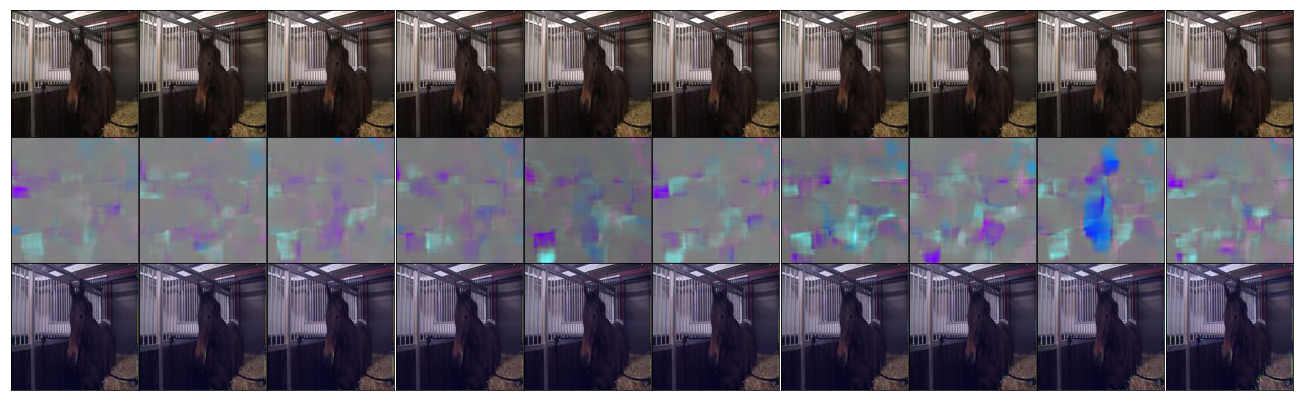

In [17]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=0)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  0
Start index in subject dataframe:  9448
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_002195.jpg     1
1  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_002196.jpg     1
2  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_002197.jpg     1
3  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_002198.jpg     1
4  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_002199.jpg     1
5  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_002200.jpg     1
6  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_002201.jpg     1
7  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_002202.jpg     1
8  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_002203.jpg     1
9  data/jpg_128_128_2fps/horse_1/1_3a_1/frame_002204.jpg     1
[[[5.2394116e-01 4.4692525e-01]
  [8.5056230e-02 8.0631679e-01]
  [3.5557731e-03 9.3380100e-01]
  [6.9316698e-04 9.6725744e-01]
  [2.9301838e-04 9.7856218e-01]
  [2.5932162e-04 9.8582375e-01]
  [3.4549323e-04 9.9031138e-01]
  [5.0126435e-04 9.9050307

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


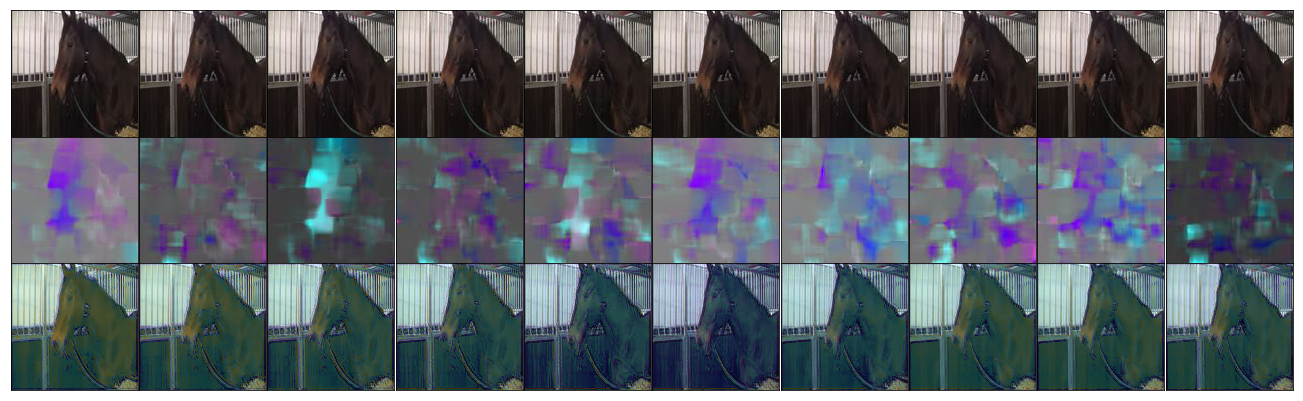

In [18]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=0)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  0
Start index in subject dataframe:  10033
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_1/1_3a_2/frame_000440.jpg     1
1  data/jpg_128_128_2fps/horse_1/1_3a_2/frame_000441.jpg     1
2  data/jpg_128_128_2fps/horse_1/1_3a_2/frame_000442.jpg     1
3  data/jpg_128_128_2fps/horse_1/1_3a_2/frame_000443.jpg     1
4  data/jpg_128_128_2fps/horse_1/1_3a_2/frame_000444.jpg     1
5  data/jpg_128_128_2fps/horse_1/1_3a_2/frame_000445.jpg     1
6  data/jpg_128_128_2fps/horse_1/1_3a_2/frame_000446.jpg     1
7  data/jpg_128_128_2fps/horse_1/1_3a_2/frame_000447.jpg     1
8  data/jpg_128_128_2fps/horse_1/1_3a_2/frame_000448.jpg     1
9  data/jpg_128_128_2fps/horse_1/1_3a_2/frame_000449.jpg     1
[[[0.513445   0.47547567]
  [0.23985466 0.65262944]
  [0.05789103 0.6674491 ]
  [0.03251462 0.5638516 ]
  [0.02634464 0.57629263]
  [0.02413846 0.6319142 ]
  [0.03123572 0.644102  ]
  [0.04199598 0.64033747]
  [0.05466091 0.6266113 ]
  [0.05597928 0

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


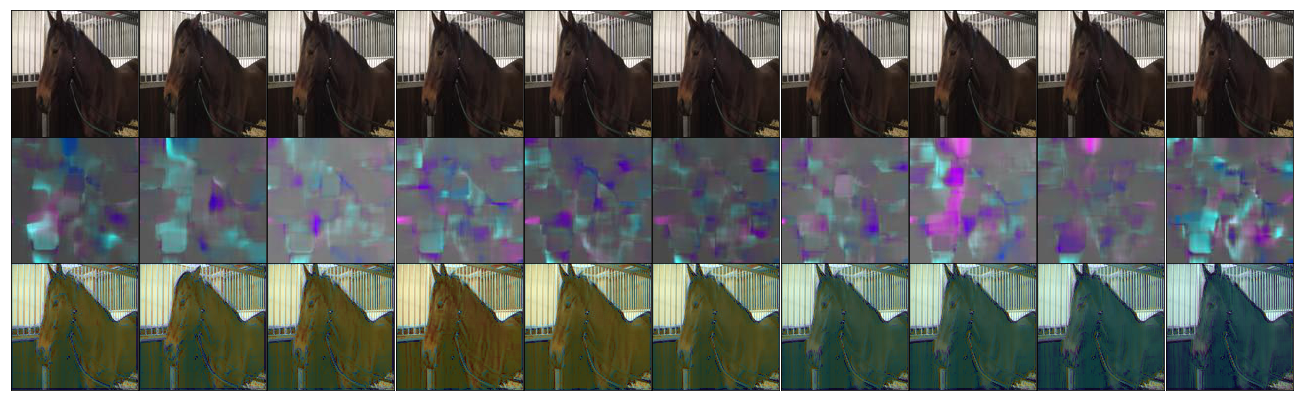

In [19]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=0)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  0
Start index in subject dataframe:  4889
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_1/1_2a/frame_001242.jpg     0
1  data/jpg_128_128_2fps/horse_1/1_2a/frame_001243.jpg     0
2  data/jpg_128_128_2fps/horse_1/1_2a/frame_001244.jpg     0
3  data/jpg_128_128_2fps/horse_1/1_2a/frame_001245.jpg     0
4  data/jpg_128_128_2fps/horse_1/1_2a/frame_001246.jpg     0
5  data/jpg_128_128_2fps/horse_1/1_2a/frame_001247.jpg     0
6  data/jpg_128_128_2fps/horse_1/1_2a/frame_001248.jpg     0
7  data/jpg_128_128_2fps/horse_1/1_2a/frame_001249.jpg     0
8  data/jpg_128_128_2fps/horse_1/1_2a/frame_001250.jpg     0
9  data/jpg_128_128_2fps/horse_1/1_2a/frame_001251.jpg     0
[[[0.66479737 0.2734313 ]
  [0.8168877  0.15608846]
  [0.773387   0.06076894]
  [0.81133604 0.0232032 ]
  [0.83413935 0.01777233]
  [0.8323413  0.01517731]
  [0.8094187  0.01631691]
  [0.7640307  0.01478247]
  [0.79221493 0.01399225]
  [0.81407815 0.01702611]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


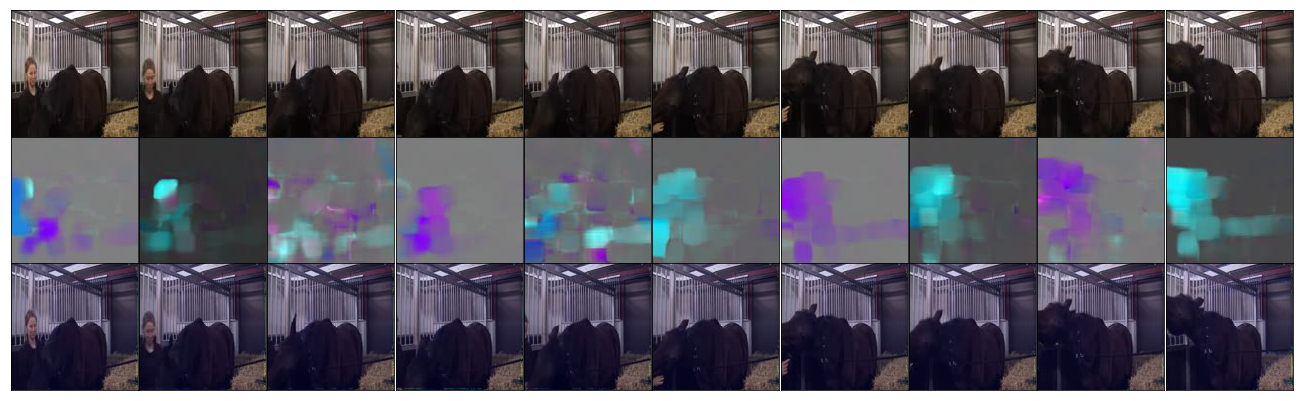

In [20]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=0)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);